This part is intended to illustrate some basic intuitions around artificial speech synthesis, focusing on vowels. To this end, a basic model for vowels is employed that comprises two components:

1) A buzzer that simulates the glottis and provides the fundamental frequency.

2) A filter that simulates the vocal tract and provides the formants.

More advanced methods incorporate models for consonants / voiceless sounds as well as modulating pitches and formants while a vowel is expressed. In this simple tutorial, though, we will be focusing on "static" vowels both in terms of pitch and formants.

Linear Predictive Coding (LPC) is a techique that employs the above mentioned ideas (in a more sophisticated manner) for speech synthesis. LPC was being used in software since 1970s; a famous toy for children, "Speak and Spell", used this technique:

https://youtu.be/cgNAqh4Mg9Q

/var/folders/k_/fvgjkvys5yq973r5xjs_hknc0000gp/T/ipykernel_10828/808299097.py:14: FutureWarning: Pass fmin=50, fmax=1000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch = librosa.yin(y, 50, 1000)


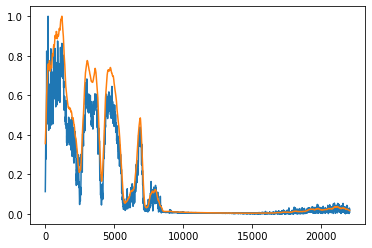

In [1]:
import numpy as np
import numpy.matlib
import librosa
import matplotlib.pyplot as plt
import sounddevice as sd
import time

# demo file, before running for a batch of files
file_name = 'audio_files/ah/ah_0.wav'

# load waveform
y, sr = librosa.load(file_name, sr=44100)
# find mean pitch
pitch = librosa.yin(y, 50, 1000)
fr = np.mean(pitch)

# apply fft
n_fft = 8096
hop_size = 256

p = librosa.stft(y, n_fft=n_fft, hop_length=hop_size)
d = librosa.amplitude_to_db( np.abs(p), ref=np.max )
freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

# get mean of spectral amplitude across all time instances
m = np.mean( d , axis=1 )
# and place it on 0 level
m -= np.min( m )

# helper function - moving average - for smoothing out the spectrum
def moving_average(x, w):
    x = np.hstack( ( x[0]*np.ones(w//2) , x , x[-1]*np.ones(w//2-1) ) )
    ma = np.convolve(x, np.ones(w), 'valid') / w
    return ma

# apply moving average to spectrum and plot both
a = moving_average(m,50)
a /= np.max( a )

plt.plot( freqs , m/np.max(m) )
plt.plot( freqs , a )

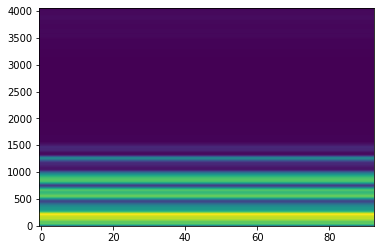

In [2]:
# use the moving average curve as spectral filter for formants - simulating the vocal tract component
f = numpy.matlib.repmat( a , p.shape[1], 1 ).T
plt.imshow(f, origin='lower', aspect='auto')

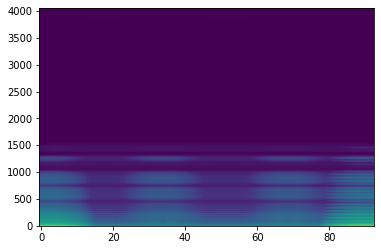

In [3]:
# make buzzing component - simulated with a sawtooth waveform
n = np.arange( y.size )
x = (n%(sr/fr))/(sr/fr)
# and apply fft to it - for applying ifft afterwards
xp = librosa.stft(x, n_fft=n_fft, hop_length=hop_size)

# apply formants filter
px = xp*f
x1 = librosa.istft(px, hop_length=hop_size)

# show result
dpx = librosa.amplitude_to_db( np.abs(px), ref=np.max )
plt.imshow(dpx, origin='lower', aspect='auto')

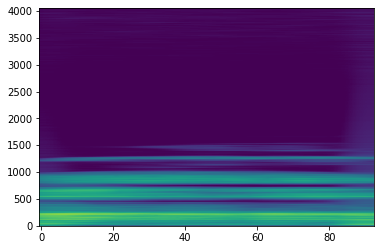

In [4]:
# show recording spectrum for comparison
plt.imshow(d, origin='lower', aspect='auto')

In [5]:
# run batch
file_names = ['audio_files/ah/ah_0.wav',
              'audio_files/oh/oh_0.wav',
              'audio_files/eeh/eeh_0.wav',
              'audio_files/ah/ah_1.wav',
              'audio_files/oh/oh_1.wav',
              'audio_files/eeh/eeh_1.wav',
              'audio_files/ah/ah_2.wav',
              'audio_files/oh/oh_2.wav',
              'audio_files/eeh/eeh_2.wav']
sythesized = np.zeros(0)
recorded = np.zeros(0)


for i, file_name in enumerate(file_names):
    y, sr = librosa.load(file_name, sr=44100)
    
    pitch = librosa.yin(y, 50, 1000)
    fr = np.mean(pitch)
    
    n_fft = 8096
    hop_size = 256
    
    p = librosa.stft(y, n_fft=n_fft, hop_length=hop_size)
    d = librosa.amplitude_to_db( np.abs(p), ref=np.max )
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    
    m = np.mean( d , axis=1 )
    m -= np.min( m )
    
    def moving_average(x, w):
        x = np.hstack( ( x[0]*np.ones(w//2) , x , x[-1]*np.ones(w//2-1) ) )
        ma = np.convolve(x, np.ones(w), 'valid') / w
        return ma
    
    a = moving_average(m,50)
    a /= np.max( a )
    
    # filter
    f = numpy.matlib.repmat( a , p.shape[1], 1 ).T
    
    # make saw
    n = np.arange( y.size )
    x = (n%(sr/fr))/(sr/fr)
    xp = librosa.stft(x, n_fft=n_fft, hop_length=hop_size)
    
    px = xp*f
    x1 = librosa.istft(px, hop_length=hop_size)
    
    dpx = librosa.amplitude_to_db( np.abs(px), ref=np.max )
    
    sythesized = np.hstack( (sythesized,x1) )
    recorded = np.hstack( (recorded,y) )

sd.play( recorded, sr )
time.sleep( recorded.size/sr + 0.5 )
sd.play( sythesized , sr )

/var/folders/k_/fvgjkvys5yq973r5xjs_hknc0000gp/T/ipykernel_10828/371735534.py:18: FutureWarning: Pass fmin=50, fmax=1000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch = librosa.yin(y, 50, 1000)
